In [9]:
%matplotlib notebook
# %autosave 10
# %lsmagic
# print(plt.style.available)

import numpy as np
import subprocess as sp
import os
import PT
from matplotlib import gridspec
from matplotlib import pyplot as plt
from pylab import savefig
import mSMOOTH

#<span class="mark">read atoms.dat and feff.inp</span>

In [39]:



def read_atomsdat(file):
    af   = np.loadtxt(file, unpack=True, skiprows=2, comments='#')
    af = af.T
    pos_fromatoms = af[:,0:4]
    labels = af[:,3]
    return pos_fromatoms



def read_feffinp(file):
    with open(file, mode='r') as f:
        lines = f.readlines()

    ZPs = []
    for i, line in enumerate(lines):
        if 'POTENTIALS' in line:
            kl = i
            while True:
                t = lines[kl+1].split() 
                if len(t) < 2:
                    break
                if t[0] is '*':
                    print('')
                else: ZPs.append((lines[kl+1].split()[0:3]))                           
                kl += 1

    pos = []
    for i, line in enumerate(lines):
        if 'ATOMS' in line:
            kl = i
            while True:
                t = lines[kl+1].split() 
                if len(t) < 4:
                    break
                if t[0] is '*':
                    print('')
                else: pos.append((lines[kl+1].split()[0:4]))                           
                kl += 1          
    pos = np.array(pos, np.float)
  
        
    # find central atom
    n = 0
    for i in pos[:,3]:
        if int(i) == 0:
            central_atom_index = n
            break
        n+=1
        
    # calculate distances to central atom  
    d2cs = []
    for i in range(len(pos)):
        p0 = pos[central_atom_index]
        pi = pos[i]
        d = (p0[0]-pi[0])**2 + (p0[1]-pi[1])**2 + (p0[2]-pi[2])**2
        d = np.sqrt(d)
        d2cs.append(d) 
        
    # Generate Zs list   
    alabels = []
    Zs = []
    for i in range(len(pos)):
        for l in ZPs:
            if int(pos[i][3]) == int(l[0]):
                Zs.append(int(l[1]))
                alabels.append(l[2])
            
    # combine and sort
    labels  = []
    pos_new = []
    for i in range(len(pos)):
#         t = [pos[i][0],pos[i][1],pos[i][2],int(pos[i][3]),int(Zs[i]),alabels[i],d2cs[i]]
        t = [pos[i][0],pos[i][1],pos[i][2],int(pos[i][3]),int(Zs[i]),d2cs[i]]        
        pos_new.append(t)     
    pos_new.sort(key=lambda x: x[5]) 
    
    d2cs = []
    for i in pos_new:
        d2cs.append(i[5])
        
    positions = pos_new    
        
    return positions, d2cs


def pos2coulomb(pos):
    Zs = []
    for z in pos:
        Zs.append(z[4])
    coulomb_matrix = np.zeros((len(Zs), len(Zs)))
    for i in range(len(Zs)):
        for j in range(len(Zs)):
            p1 = pos[i]; Z1 = Zs[i]
            p2 = pos[j]; Z2 = Zs[j]
            d = (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2
            d = np.sqrt(d)
            if i == j:
                coulomb_matrix[i,j] = 0.5*(Z2**2.4)
            else: coulomb_matrix[i,j] = Z1*Z2/d**1        
    return coulomb_matrix


def pos2gr(pos,order,dmax,dr):
    d2cs = []
    Zs   = []
    Vs   = []
    for p in pos:
        Zs.append(p[4])
        s=PT.get_s(p[4])
        Vs.append(PT.get_v(s))       
        d2cs.append(p[5]) 
            
    grx = d2cs
    
    gryZ = [0];gryV = [0]     
    for i in range(1,len(pos)):
        gryZ.append(Zs[0]*Zs[i]/(d2cs[i]**order))
        gryV.append(Vs[0]*Vs[i]/(d2cs[i]**order))    

    x_new = np.arange(1, dmax+dr, dr)
    y_newZ = x_new*0;y_newV = x_new*0
    
    for j in range(len(grx)):
        p = grx[j]
        y_tmpZ = x_new*0
        y_tmpV = x_new*0        
        for i in range(len(x_new)-1):
            if ( p >= x_new[i] and p < x_new[i+1] ):
                y_newZ[i] = gryZ[j]
                y_newV[i] = gryV[j]                
        y_newZ = y_newZ + y_tmpZ
        y_newV = y_newV + y_tmpV
    
    gr = [x_new,y_newZ,y_newV]                   
           
    return gr


def pos2xyz(pos):
    f = open('atoms.xyz', 'w')   
    f.write(str(len(pos))+' \n')
    f.write('C \n')     
    for i in pos:
        l = PT.get_s(i[4])
        f.write('%3s   %13.6f%13.6f%13.6f   %2d  %2d %6.3f\n' % (l, i[0], i[1], i[2], i[3], i[4],i[5]))            
    f.close()
    return


def read_xmu(file=None):
    if file is None: file='xmu.dat'
    xmu = np.loadtxt(file, unpack=True, comments='#', usecols=(0,1,3), skiprows=0)
    return xmu
    

    
def readfeff(cleankey=None,plotkey=None,grorder=None,grdmax=None,grdr=None,sigma=None):

    if cleankey is None: cleankey=1
    if plotkey is None: plotkey=1    
    if sigma is None: sigma=0.1
    if grorder is None: grorder=3 
    if grdmax is None: grdmax=6
    if grdr is None: grdr=0.05          

    if os.path.isfile('feff.inp') == False:
        print('no feff.inp here !!!,... quitting.')
        return
    
    positions, d2cs = read_feffinp('feff.inp')
    pos2xyz(positions)
    
    if os.path.isfile('xmu.dat') == True:
        xmu = read_xmu()
    else: xmu = []
    
    gr = []
    gr_s = []
    
        
      
    os.remove('feff.npz') if os.path.exists('feff.npz') else None    
    np.savez('feff.npz', _gr_s=gr_s, _gr=gr, _xmu=xmu, _positions=positions)    
    sp.call('zip -qur feff.npz feff.inp xmu.dat', shell=True) 
    
    if os.path.isfile('atoms.dat') == True: 
        sp.call('zip -qur feff.npz atoms.dat; rm -f atoms.dat', shell=True) 
    if os.path.isfile('atoms.xyz') == True: 
        sp.call('zip -qur feff.npz atoms.xyz', shell=True) 
        
    coulomb_matrix = pos2coulomb(positions)
    np.save('_coulomb_matrix', coulomb_matrix)
    gr = pos2gr(positions,grorder,grdmax,grdr)
    grx, gZr = gr[0], gr[1]
    grx, gVr = gr[0], gr[2] 
    grx_s, gZr_s = mSMOOTH.Gaussian(grx, gZr,sigma)       
    grx_s, gVr_s = mSMOOTH.Gaussian(grx, gVr,sigma)      
    np.save('_gr', gr)
    np.save('_gr_s', [grx_s,gZr_s,gVr_s])       
    sp.call('zip -qur feff.npz _coulomb_matrix.npy _gr.npy _gr_s.npy  ', shell=True)
    sp.call('rm -f _coulomb_matrix.npy _gr.npy _gr_s.npy  ', shell=True)    
    
    
        

    if plotkey == 1:
                
        from matplotlib import gridspec
        fig = plt.figure(figsize=(7,8))
        gs1 = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[0.5,0.3] )
        gs1.update(top=0.95, bottom=0.07, left=0.06, right=0.97, wspace=0.2, hspace=0.3)

        gs2 = gridspec.GridSpec(4, 2 )
        gs2.update(top=0.95, bottom=0.07, left=0.09, right=0.95, wspace=0.4, hspace=0.3)

        ax=fig.add_subplot(gs1[0])        
        ax.matshow(coulomb_matrix)

        ax=fig.add_subplot(gs1[1])
        ax.plot(np.arange(0,len(d2cs)),d2cs,'-r')
        uniq = []
        for i in range(len(positions)):
            ax.plot(i,positions[i][5],'C'+str(positions[i][3])+'o',ms=4)
            t = [positions[i][3],positions[i][4]]
            if t not in uniq: uniq.append(t)
        for i in range(len(uniq)):
            ax.plot([0],[0],'C'+str(uniq[i][0])+'o',ms=4,label=PT.get_s(uniq[i][1]))
        ax.plot([0],[0],'C0o')
        ax.legend(loc='best',fontsize=6,ncol=6)
        ax.set_xlabel('Atom index #')
        ax.set_ylabel('nn distance ($\AA$)')

        ax=fig.add_subplot(gs2[4])
        ax.plot(grx,gZr,'-r.',ms=4)
        ax.plot(grx_s,gZr_s,'-k')        
        ax.set_ylabel('gZ($r$)')        
        ax=fig.add_subplot(gs2[6])
        ax.plot(grx,gVr,'-r.',ms=4)
        ax.plot(grx_s,gVr_s,'-k')        
        ax.set_xlabel('Distance to core $r$ ($\AA$)')
        ax.set_ylabel('gV($r$)')  
  
        if not len(xmu) == 0:            
            ax1=fig.add_subplot(gs1[3])
            ax1.plot(xmu[0],xmu[2],'-k')      
            ax1.set_xlabel('Energy (eV)')
            ax1.set_ylabel('Normalized $\mu$(E)')  
            ax2 = ax1.twiny()
            ax2.plot(xmu[1],xmu[2],'-k')
        
        savefig('feff.png', format='png', dpi=300)
        sp.call('zip -qur feff.npz feff.png', shell=True)


    if cleankey == 1:
        all_files = os.listdir()
        all_files.remove('feff.npz')
        all_files.remove('feff.png')
        all_files.remove('feff.inp')
        all_files.remove('xmu.dat')        
        for f in all_files:
            os.remove(f)

        

 
    return positions, coulomb_matrix, gr, xmu






def loadfeff():
    
    if os.path.isfile('feff.npz') == False:
        positions, gr, gr_s, xmu = readfeff()
    else: 
        readdata = np.load('feff.npz')
        positions = readdata['_positions']
        gr = readdata['_gr']
        gr_s = readdata['_gr_s']
        xmu = readdata['_xmu']
    
    return positions, gr, gr_s, xmu 







<IPython.core.display.Javascript object>


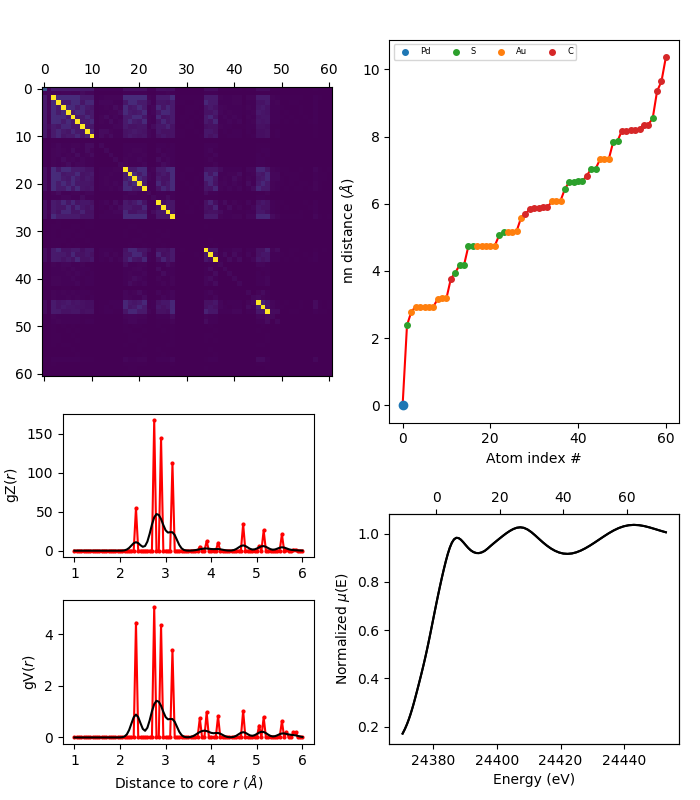

In [46]:
os.chdir('r')
positions, gr, gr_s, xmu = readfeff(cleankey=1)
os.chdir('..')

In [47]:
positions

[[2.3733157553021913, 1.4667898028123827, 0.0, 0, 46, 0.0],
 [3.7715907535921724,
  3.3927251675526309,
  2.3585905797938355e-16,
  2,
  16,
  2.3799999999999999],
 [0.0, 0.0, 0.0, 1, 79, 2.7899999999999996],
 [2.3733157553021913, -1.4667898028123827, 0.0, 1, 79, 2.9335796056247654],
 [0.0, 2.3733157553021913, 1.4667898028123827, 1, 79, 2.9335796056247654],
 [0.0, 2.3733157553021913, -1.4667898028123827, 1, 79, 2.9335796056247654],
 [1.4667898028123827, 0.0, 2.3733157553021913, 1, 79, 2.9335796056247654],
 [1.4667898028123827, 0.0, -2.3733157553021913, 1, 79, 2.9335796056247654],
 [1.7850145547788809,
  4.5715444948070392,
  3.802227895688982e-16,
  1,
  79,
  3.1600000000000001],
 [4.5715444948070392,
  1.901113947844491e-16,
  1.7850145547788807,
  1,
  79,
  3.1890372963626352],
 [4.5715444948070392,
  1.901113947844491e-16,
  -1.7850145547788818,
  1,
  79,
  3.1890372963626357],
 [5.6115907535921732,
  3.3927251675526309,
  2.3585905797938355e-16,
  3,
  6,
  3.7677117715806148],


In [49]:
os.chdir('r')
positions, gr, gr_s, xmu = loadfeff()
os.chdir('..')

In [50]:
positions

array([[  2.37331576e+00,   1.46678980e+00,   0.00000000e+00,
          0.00000000e+00,   4.60000000e+01,   0.00000000e+00],
       [  3.77159075e+00,   3.39272517e+00,   2.35859058e-16,
          2.00000000e+00,   1.60000000e+01,   2.38000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   7.90000000e+01,   2.79000000e+00],
       [  2.37331576e+00,  -1.46678980e+00,   0.00000000e+00,
          1.00000000e+00,   7.90000000e+01,   2.93357961e+00],
       [  0.00000000e+00,   2.37331576e+00,   1.46678980e+00,
          1.00000000e+00,   7.90000000e+01,   2.93357961e+00],
       [  0.00000000e+00,   2.37331576e+00,  -1.46678980e+00,
          1.00000000e+00,   7.90000000e+01,   2.93357961e+00],
       [  1.46678980e+00,   0.00000000e+00,   2.37331576e+00,
          1.00000000e+00,   7.90000000e+01,   2.93357961e+00],
       [  1.46678980e+00,   0.00000000e+00,  -2.37331576e+00,
          1.00000000e+00,   7.90000000e+01,   2.93357961e+00],
